# Extracellular
Generates data from simulated extracellular recordings for studying with spike sorting etc. We run the same simulation as in DryWetLab, but use extracellular measurements to count spikes and check interspike interval distribution.

In [1]:
%matplotlib nbagg
from tqdm import tqdm_notebook as tqdm
import itertools

import numpy as np
from scipy import stats, signal, ndimage, sparse
import scipy.integrate as spint
import scipy.interpolate as spolate 
import matplotlib.pyplot as plt
import matplotlib.animation as animation

from colorednoise import powerlaw_psd_gaussian as gen_noise
from braingeneers import drylab

In [2]:
# Number of neurons, followed by the number which are excitatory.
N = 1000
Ne = 950

# Sample rate (kHz) and timestep (ms)
fs = 10
dt = 1/fs

# How much stronger inhibitory connections are than excitatory ones.
inhibition_factor = 2

# Used for constructing nonhomogeneous neural populations,
# interpolated between two types based on the value of
# r ∈ [0,1]. Excitatory neurons go from Regular Spiking
# to Chattering, while inhibitory neurons go from
# Low-Threshold Spiking to Late Spiking models over the
# same range. Adapted from Izhikevich's writings.
r = np.random.rand(N) # unitless
l = np.ones(N) # unitless

# a : 1/ms recovery time constant of membrane leak currents
a = np.hstack((0.03*l[:Ne], 0.03 + 0.14*r[Ne:]))
# b : nS recovery conductivity
b = np.hstack((-2 + 3*r[:Ne]**2, 8 - 3*r[Ne:]))
# c : mV voltage of the downstroke
c = np.hstack((-50 + 10*r[:Ne]**2, -53 + 8*r[Ne:]))
# d : pA instantaneous increase in leakage during downstroke
d = np.hstack((100 + 50*r[:Ne]**2, 20 + 80*r[Ne:]))
# C : pF membrane capacitance
C = np.hstack((100 - 50*r[:Ne]**2, 100 - 80*r[Ne:]))
# k : nS/mV Na+ voltage-gated channel conductivity parameter
k = np.hstack((0.7 + 0.8*r[:Ne]**2, 1 - 0.7*r[Ne:]))
# mV : resting membrane voltage
Vr = np.hstack((-60*l[:Ne], -56 - 10*r[Ne:]))
# mV : threshold voltage at u=0
Vt = np.hstack((-40*l[:Ne], -42 + 2*r[Ne:]))

# tau : ms time constant of synaptic current
tau = 20

# Sij : pA total EPSC generated in neuron i when neuron j fires.
mu, sigma = -0.702, 0.9355  # taken from Song (2005).
S = np.random.lognormal(mean=mu, sigma=sigma, size=(N,N))
S *= np.median(C / tau)
S[:,Ne:] *= -inhibition_factor
S[Ne:,Ne:] = 0 # prevent inhibitory cells from synapsing on each other
S[Ne:,:Ne] *= 2 # make excitatory input to inhibitory cells stronger

# XY : um planar positions of the cells
XY = 70 * np.random.rand(2,N)

# Direct Diffusion
Instead of computing this nasty analytic solution that takes forever, let's try propagating the diffusion equation forward in time with a Gaussian blur of variance $D\,\mathrm{d}t$. Time is now quantized, but that shouldn't hurt much. The diffusion constant is the value for $\text{Cl}^-$ from [an online table](https://biofilmbook.hypertextbookshop.com/public_version/artifacts/tables/Module_004/Table4-1_DiffCoeffH2O.htm). This value was chosen because I needed *something* and this is the first electrophysiologically important ion I found a value for.

In [3]:
# %%time
# Run the simulation the usual way...
tmax = 1000

org = drylab.Organoid(XY=XY, S=S, tau=tau,
                      a=a, b=b, c=c, d=d,
                      k=k, C=C, Vr=Vr, Vt=Vt)

# Construct the grid of probe points.
n_probes = 8
theta = np.linspace(0, 2*np.pi, num=n_probes+1)[:-1]
points = np.array([np.cos(theta), np.sin(theta)]) * 30 + 35
d_neuron = np.linalg.norm(points[:,...,None] - XY[:,None,...], 
                          axis=0)
probe_closest_to = np.argmin(d_neuron, axis=0)

# The ridiculously nonphysical implementation of a probe.
u = drylab.ElectrodeArray(points=points, activation=None, radius=1)
u.insert(org, Vr, org.C/1e4)#pF "medium capacitance"


In [4]:
time = np.linspace(0, tmax, tmax*fs + 1)
pinks = gen_noise(size=(N,len(time)), exponent=1) * 50

# Charged medium with tensor product grid in micron units.
X = Y = np.linspace(0,70, 101)
med = drylab.ChargedMedium(X, Y, D=2, eps_rel=80)
med.immerse(org)

# Initialize and run the loop.
org.reset()
spike_times, spike_idces = [], []
states_naive = np.zeros((n_probes, len(time)))
states_med = np.zeros((n_probes, len(time)))
for ti,t in tqdm(enumerate(time), total=len(time)):
    
    _, fired = org.step(dt, pinks[:,ti])
    med.step(dt)
    states_med[:,ti] = med.probe(points)
    states_naive[:,ti] = u.Vprobe()
    
    for i in np.arange(N)[fired]:
        spike_times.append(t)
        spike_idces.append(i)

spike_times = np.array(spike_times)
spike_idces = np.array(spike_idces, dtype=np.int32)
ground_truth_spikes = [
    spike_times[probe_closest_to[spike_idces] == i]
    for i in range(n_probes)]

# Sanity Check
Plot the simulation results in terms of both probe voltages and spectrum. We compare the extracellular voltages generated by assuming instantaneous propagation with $1/r$ falloff (this is ridiculous and arbitrary) vs. solving the diffusion equation.

<IPython.core.display.Javascript object>


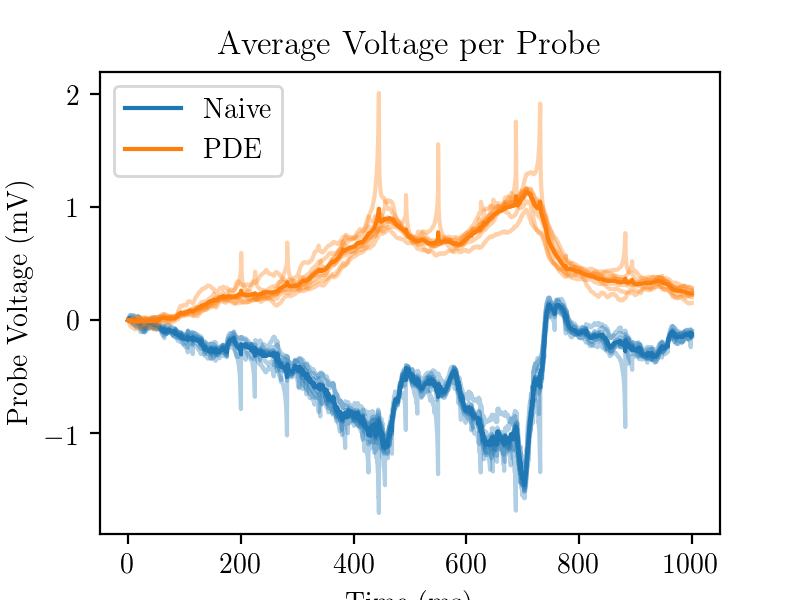

In [5]:
plt.figure()

for probe in range(n_probes):
    plt.plot(time, states_naive[probe,:], 
             color='C0', alpha=1/np.sqrt(n_probes))
plt.plot(time, states_naive.mean(axis=0), label='Naive')

for probe in range(n_probes):
    plt.plot(time, states_med[probe,:], 
             color='C1', alpha=1/np.sqrt(n_probes))
plt.plot(time, states_med.mean(axis=0), label='PDE')

plt.legend()
plt.title('Average Voltage per Probe')
plt.xlabel('Time (ms)')
plt.ylabel('Probe Voltage (mV)')
None

In [6]:
freq_med, psds_med = signal.welch(states_med, fs)
freq_naive, psds_naive = signal.welch(states_naive, fs)

<IPython.core.display.Javascript object>


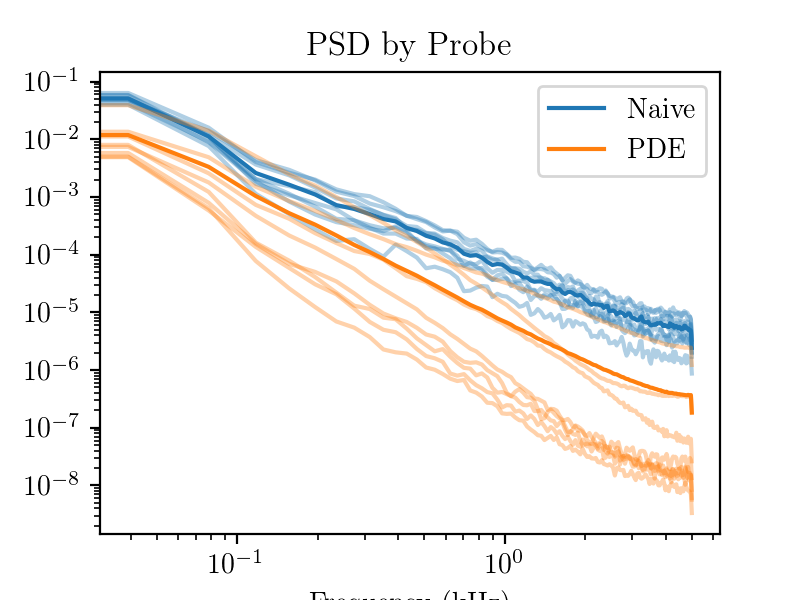

In [7]:
plt.figure()

for probe in range(n_probes):
    plt.loglog(freq_naive, psds_naive[probe,:], 
             color='C0', alpha=1/np.sqrt(n_probes))
plt.loglog(freq_naive, psds_naive.mean(axis=0), label='Naive')

for probe in range(n_probes):
    plt.loglog(freq_med, psds_med[probe,:], 
             color='C1', alpha=1/np.sqrt(n_probes))
plt.loglog(freq_med, psds_med.mean(axis=0), label='PDE')

plt.legend()
plt.title('PSD by Probe')
plt.xlabel('Frequency (kHz)')
None

# Filtering
Electrophysiological data usually bandpass filters over something like 250Hz to 3kHz to remove LFPs. The sampling rate is only 1kHz here though, so there's no need for the high-cut part, just a high-pass at 250Hz.

In [8]:
def butter_bandpass(x, locut, hicut, fs, order=5):
    "Apply a Butterworth bandpass filter."
    sos = signal.butter(order, [locut, hicut], fs=fs,
                        btype='bandpass', output='sos')
    return signal.sosfilt(sos, x)

In [9]:
statesf = butter_bandpass(states_med, 0.25, 3, fs=fs, order=5)

<IPython.core.display.Javascript object>


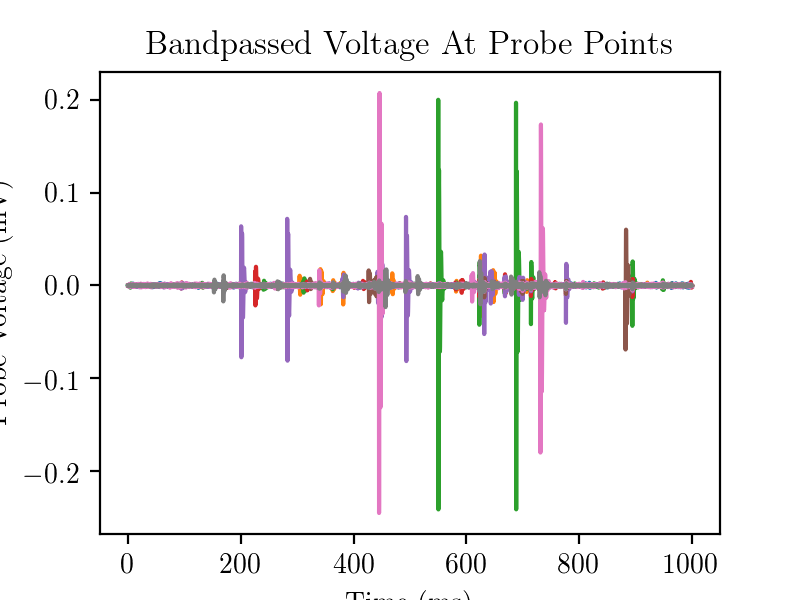

In [10]:
plt.figure(figsize=(4,3))
plt.plot(time, statesf.T)
plt.title('Bandpassed Voltage At Probe Points')
plt.xlabel('Time (ms)')
plt.ylabel('Probe Voltage (mV)')
None

# Rudimentary Spike Sorting
Use the same simple threshold-based method as Keith to find the spikes in both of those recordings, and compare them with the ground truth.

In [11]:
def find_spikes(time, x, threshold=20e-3):
    """
    Finds spikes, where the voltage dips below a negative
    threshold and returns their onset times.
    """
    channels, events = np.nonzero(
        np.diff(np.int32(x < -threshold),
                axis=1) == 1)
    return channels, time[events]

def firings_to_raster(channels, events):
    """
    Given a list of spike times plus what channel each one
    occurred on, returns a list of arrays of spikes suitable
    for raster plotting etc.
    """
    return [events[channels == i]
            for i in range(channels.max() + 1)]

def find_spikes_by_channel(time, x, *args, **kwargs):
    return firings_to_raster(*find_spikes(time, x, *args, **kwargs))

In [12]:
thresh = 0.02
spikes_per_channel = find_spikes_by_channel(time, statesf, threshold=thresh)

<IPython.core.display.Javascript object>


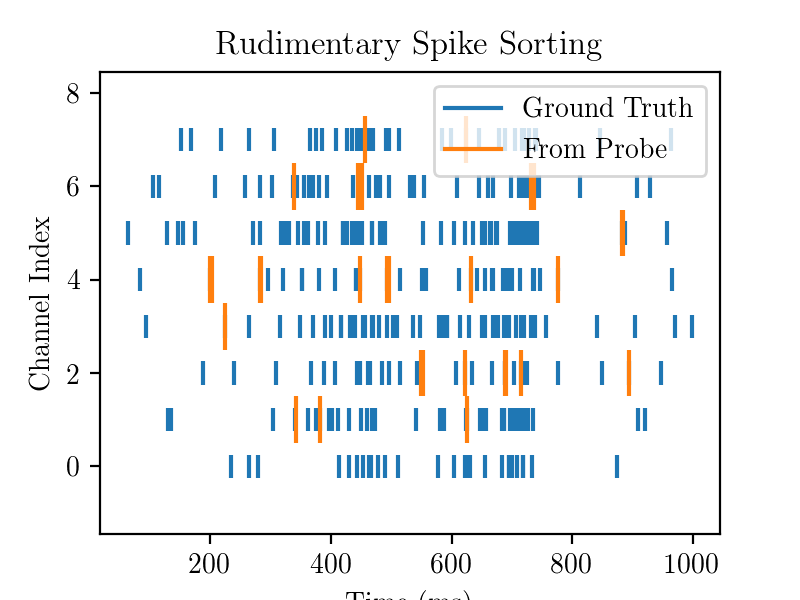

Text(0, 0.5, 'Channel Index')

In [13]:
plt.figure(figsize=(4,3))
plt.plot([], [], label='Ground Truth')
plt.plot([], [], label='From Probe')
plt.eventplot(ground_truth_spikes, color='C0', alpha=1, linelengths=0.5)
plt.eventplot(spikes_per_channel, color='C1', alpha=1)
plt.legend()
plt.title('Rudimentary Spike Sorting')
plt.xlabel('Time (ms)')
plt.ylabel('Channel Index')
# plt.savefig('spiketimes.png', dpi=300, bbox_inches='tight')

<IPython.core.display.Javascript object>


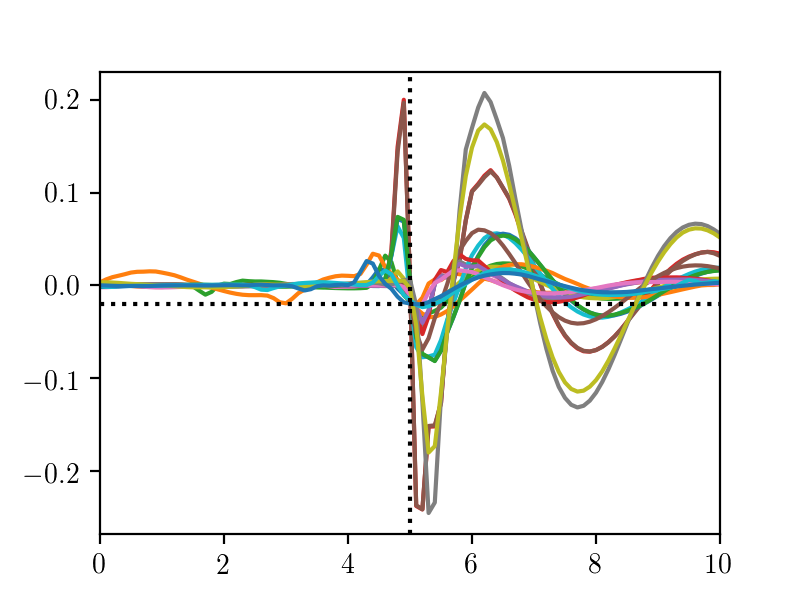

(0, 10)

In [14]:
from itertools import *
plt.figure()
wnd = 5
for chan, spikes in enumerate(spikes_per_channel):
    for prev, spike in zip(chain([0], spikes), spikes):
        if spike - prev > wnd:
            tidx = np.abs(time - spike) <= wnd
            region = statesf[chan, tidx]
            plt.plot(np.arange(len(region))*dt, region)
            
plt.axvline(x=wnd, linestyle=':', color='k')
plt.axhline(y=-thresh, linestyle=':', color='k')
plt.xlim(0, 2*wnd)

In [15]:
# Make a list of interspike intervals from all channels.
intervals = itertools.chain.from_iterable(
    np.diff(spikes_per_channel[channel])
    for channel in range(8))
intervals = np.array(list(intervals))

<IPython.core.display.Javascript object>


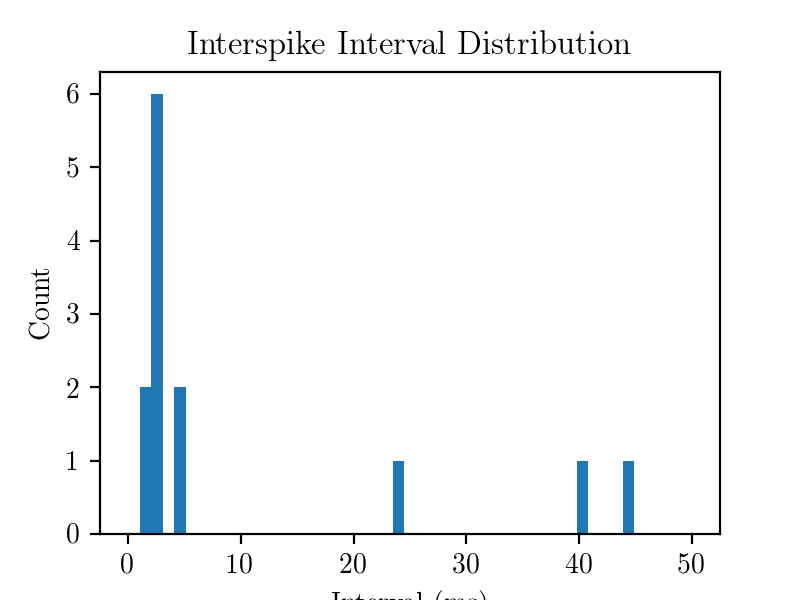

/Applications/Anaconda/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6641: RuntimeWarning: invalid value encountered in multiply
  boffset = -0.5 * dr * totwidth * (1 - 1 / nx)


In [16]:
plt.figure(figsize=(4,3))
plt.hist(intervals, list(np.linspace(0,50)) + [np.inf])
plt.title('Interspike Interval Distribution')
plt.xlabel('Interval (ms)')
plt.ylabel('Count')
None

# Probe Visualization
Just for fun, here's each cell colored according to which probe it's closest to and how much it contributes to that probe.

<IPython.core.display.Javascript object>


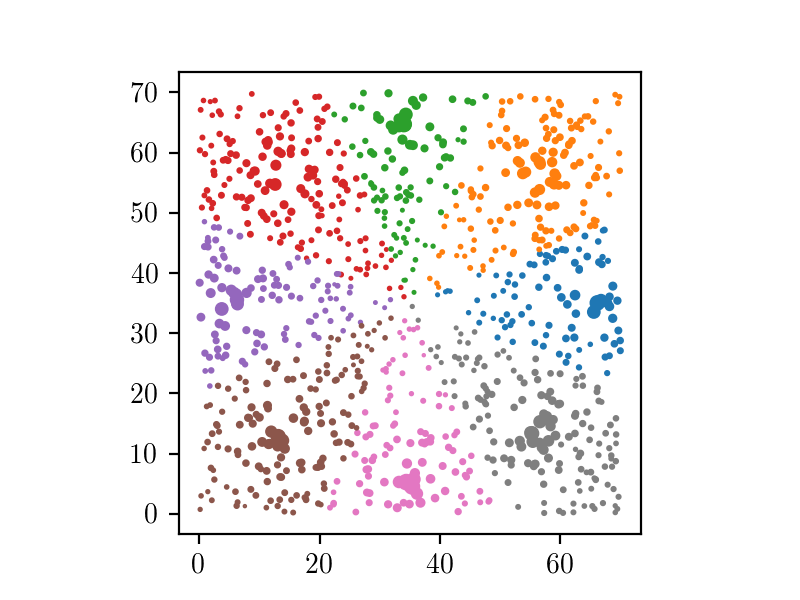

In [17]:
plt.figure()
plt.gca(aspect='equal')
colors = ['C'+str(i) for i in probe_closest_to]
plt.scatter(org.XY[0,:], org.XY[1,:], c=colors, 
            s=25 * np.max(u.M, axis=1) / np.max(u.M))